In [1]:
import os
# Check cwd
os.chdir('/home/atom/cvlab/thesis/') 
# os.chdir('/home/member/github/BS-thesis') 
# BS-thesis should be root
print(os.getcwd())

/home/atom/cvlab/thesis


In [56]:
# Dependencies
import glob, itertools
import my_pkg.dataset
import matplotlib.pyplot as plt
import numpy as np

from functools import partial
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [3]:
# reloading stuff
import importlib
importlib.reload(my_pkg.dataset);

# PCA and LDA on shape subspaces

## Introduction

Pca can be done on subspaces using the Grassmann kernel, in which case it is named Grassmann PCA (PCA).

### What's in this notebook

- First, normal PCA and LDA by flattening each frame into a vector.

## Necessary Preprocessing of data

### Reading the data

In [4]:
pose_paths = glob.glob('./data/marker/*.csv')
grf_paths = glob.glob('./data/GRF/*.csv')
info_path = './data/info.xlsx'
dataset = my_pkg.dataset.SLJDataset(pose_paths, grf_paths, info_path)

In [5]:
pose, trunc_pose, grf, label = dataset[0].values()

print(f'pose: {pose.shape}')
print(f'trunc_pose: {trunc_pose.shape}')
print(f'grf: {grf.shape}')
print(f'label: {label}')

pose: (1099, 29, 3)
trunc_pose: (542, 29, 3)
grf: (11609, 5)
label: [0 1 0 0 0 0]


### Applying a transformation to fix length

Here we will use trunc_pose (the 3D pose data right until jump landing). 

Because it is a huge array, we will crop the last 3 seconds (300 frames) and then resample it to 10hz (30 frames) from the original 100hz.

In [6]:
def transform(sample):
    sample['trunc_pose'] = sample['trunc_pose'][-300::10]
    return sample    

dataset.transforms = [transform] 
pose, trunc_pose, grf, label = dataset[0].values()

# transforms are applied on __getitem__
print(f'new trunc_pose: {trunc_pose.shape}') # should be 30

new trunc_pose: (30, 29, 3)


In [15]:
# Put all trunc poses in X and labels in Y
X, Y = [], []
for i in range(len(dataset)):
    _, trunc_pose, _, label = dataset[i].values()
    X.append(trunc_pose)
    Y.append(label)
    
#     pose, trunc_pose, _, label = dataset[i].values()
#     X.append(pose[:3])
#     Y.append(label)
    
X = np.asarray(X)
Y = np.asarray(Y)

In [16]:
# Vectorize X
d1, d2, d3, d4 = X.shape
X_vec = X.reshape(d1, d2*d3*d4)
X_vec.shape

(524, 2610)

## Normal PCA and LDA

### PCA

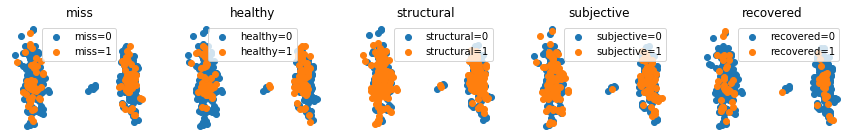

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vec)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,2))
for i, ax in enumerate(axs):
    c1 = X_pca[Y[:, i]==0]
    c2 = X_pca[Y[:, i]==1]

    ax.scatter(*c1.T, label=f'{dataset.label_info[i]}=0')
    ax.scatter(*c2.T, label=f'{dataset.label_info[i]}=1')
    
    ax.set_title(dataset.label_info[i])
    ax.legend()
    ax.axis('off')
plt.show()

### LDA

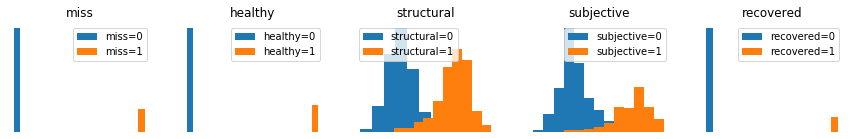

In [18]:
lda = LinearDiscriminantAnalysis()

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,2))
for i, ax in enumerate(axs):
    X_lda = lda.fit_transform(X_vec, Y[:, i])
    
    c1 = X_lda[Y[:, i]==0]
    c2 = X_lda[Y[:, i]==1]
    
    ax.hist(c1, label=f'{dataset.label_info[i]}=0')
    ax.hist(c2, label=f'{dataset.label_info[i]}=1')
    ax.set_title(dataset.label_info[i])
    ax.axis('off')
    ax.legend()

plt.show()

## Grassman Kernel PCA

### Create sequence subspace from shape subspace

#### 1. Orthonormalize the shape subspaces

Firstly, in contrast to the other methods we do not vectorize each frame but treat it as a shape subspace. However, we cannot compute the kernel as it is so we orthonormalize the columns.

We make the columns orthonormal using the gram schmidt process and dividing the resulting columns by its norm.



In [45]:
def gram_schmidt(vectors):
    '''Return orthogonal vectors in same dimension
    '''
    basis = []
    for v in vectors.transpose():
        w = v - sum( np.dot(v,b)*b  for b in basis )
        basis.append(w/np.linalg.norm(w))
    return np.array(basis)

def normalize_columns(X):
    '''Normalizes the columns of a matrix
    '''
    return np.asarray([x/np.linalg.norm(x) for x in X])


#### 2. Define the Grassmann kernel

The Grassmann kernel is defined as follows [[Fukui]](https://www.researchgate.net/publication/315865722_Three-dimensional_Object_Recognition_via_Subspace_Representation_on_a_Grassmann_Manifold):

$\mathcal{k}(\mathcal{U}, \mathcal{V}) = sim(\mathcal{U}, \mathcal{V}) = \frac{1}{n} \sum^{n}_{i=1}\cos{\theta_i}^2$

where the principle angles $\cos{\theta_i}^2$ are defined as;

$\cos \theta_i = \max_{u_k^{\top}\in \mathcal{U}} \max_{v_k^{\top}\in \mathcal{V}} u_j^{\top}v_i\\
\\
s.t.\\
u_i \perp u_j(=1,...,i−1),\, v_i \perp v_j(=1,...,i−1) \\
||u_i||=||v_i||=1\\
$


In [46]:
def canonical_angles(S1, S2):
    '''Compute canonical angles between subspace S1 and S2
    
    Warning
    -------
    S1 and S2 must be two orthonormal matrixes fo size D by m.
    Orthonormal (orthogonal) matrices are matrices in which 
    the columns vectors form an orthonormal set (each column vector 
    has length one and is orthogonal to all the other colum vectors). 
    '''
    U, S, V = np.linalg.svd(S1@S2.transpose())
    return S
    

def grassman_kernel(S1, S2):
    '''Compute similarity 
    '''
    angles = np.power(canonical_angles(S1, S2),2)
    sim = angles.mean()
    return sim

# example
# 2 different subspaces
S1 , S2 = X[0, 0], X[50, 20]
S1 = normalize_columns(gram_schmidt(S1))
S2 = normalize_columns(gram_schmidt(S2))

# should have lower value
print('Similarity with different subspaces:', grassman_kernel(S1, S2))

# should be 1
print('Similarity with identical subspaces:', grassman_kernel(S1, S1))

Similarity with different subspaces: 0.7622277591449008
Similarity with identical subspaces: 1.0000000000000007


#### 3. Compute the Grassmann kernel matrix K

For each squence we will create a subspace on the grassman kernel

In [58]:
N = 30 # length of each sequence
K = np.zeros((N, N))

for i, j in itertools.product(range(N), range(N)):
    S1 , S2 = X[0][i], X[1][j]
    S1 = normalize_columns(gram_schmidt(S1))
    S2 = normalize_columns(gram_schmidt(S2))

    K[i,j] = grassman_kernel(S1, S2)

#### 4. Compute the eigenvectors

In [59]:
# Centering the symmetric NxN kernel matrix.
N = K.shape[0]
one_n = np.ones((N,N)) / N
K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

eigvals, eigvecs = np.dual.eigh(K)
eigvals, eigvecs = eigvals[::-1], eigvecs[::-1]

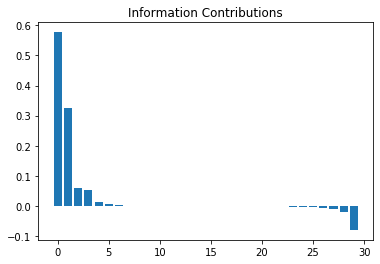

In [60]:
plt.title('Information Contributions')
plt.bar(range(len(eigvals)), height=eigvals)
plt.show()

#### 5. Pick top 5 eigen vectors to use a bases for new subspace

In [61]:
new_subspace = eigvecs[:5]

### Create class subspaces

#### 1. Create sequence subspaces of each sequence

In [63]:
seq_subspaces = []
for x in X:
    N = 30 # length of each sequence
    K = np.zeros((N, N))

    for i, j in itertools.product(range(N), range(N)):
        S1 , S2 = x[i], x[j]
        S1 = normalize_columns(gram_schmidt(S1))
        S2 = normalize_columns(gram_schmidt(S2))

        K[i,j] = grassman_kernel(S1, S2)
        
    # Centering the symmetric NxN kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    eigvals, eigvecs = np.dual.eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[::-1]

    seq_subspaces.append(eigvecs[:5])

## Kernel LDA

In [68]:
# 1. Compute the matrix K using all the seq_subspaces

N = len(dataset) 
K = np.zeros((N, N))

for S in seq_subspaces:
    for i, j in itertools.product(range(N), range(N)):
        S1 , S2 = S[i], S[j]
        S1 = normalize_columns(gram_schmidt(S1))
        S2 = normalize_columns(gram_schmidt(S2))

        K[i,j] = grassman_kernel(S1, S2)

/home/atom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [ ]:
# 2. Solve for rayleigh quotient by eigen decomposition

In [ ]:
# 1. Compute kernel matrix
K = rbf_kernel(stack_X, stack_X, self.sigma)

# 2. Center kernel matrix

In [ ]:
def gram_schmidt(vectors):
    '''Return orthogonal vectors in same dimension
    '''
    basis = []
    for v in vectors.transpose():
        w = v - sum( np.dot(v,b)*b  for b in basis )
        basis.append(w/np.linalg.norm(w))
    return np.array(basis)

def normalize_columns(X):
    '''Normalizes the columns of a matrix
    '''
    return np.asarray([x/np.linalg.norm(x) for x in X])


def canonical_angles(S1, S2):
    '''Compute canonical angles between subspace S1 and S2
    
    Warning
    -------
    S1 and S2 must be two orthonormal matrixes fo size D by m.
    Orthonormal (orthogonal) matrices are matrices in which 
    the columns vectors form an orthonormal set (each column vector 
    has length one and is orthogonal to all the other colum vectors). 
    '''
    
    U, S, V = np.linalg.svd(S1@S2.transpose())
    return S
    

def grassman_kernel(S1, S2):
    '''Compute similarity 
    '''
    angles = np.power(canonical_angles(S1, S2),2)
    sim = angles.mean()
    return sim

S1 , S2 = X[0, 0], X[50, 200]

S1 = normalize_columns(gram_schmidt(S1))
S2 = normalize_columns(gram_schmidt(S2))

grassman_kernel(S1, S2)

In [ ]:
import torch
def similarity(x, y, transpose = True):
    if transpose == True:
        x = x.t()

    U, S, V = torch.mm(x,y).svd()
    # mean of canonical angles
    return S.pow(2).mean()

similarity(torch.tensor(S1), torch.tensor(S2))

In [ ]:
def is_orthogonal(X):
    # is matrix X orthogonal?
    tp = ((X.transpose(0,1).matmul(X) - torch.eye(X.shape[1])) > 0.01)
    return False if tp.sum() > 0 else True

def is_normalized(X):
    # are the columns of X normalized?
    tp = torch.norm(X, dim=0).mean()
    return False if tp > 1.001 or tp < 0.999 else True


In [ ]:
from itertools import combinations



In [ ]:

gram_schmidt(v)

In [ ]:
def gs(X, row_vecs=True, norm = True):
    if not row_vecs:
        X = X.T
    Y = X[0:1,:].copy()
    for i in range(1, X.shape[0]):
        proj = np.diag((X[i,:].dot(Y.T)/np.linalg.norm(Y,axis=1)**2).flat).dot(Y)
        Y = np.vstack((Y, X[i,:] - proj.sum(0)))
    if norm:
        Y = np.diag(1/np.linalg.norm(Y,axis=1)).dot(Y)
    if row_vecs:
        return Y
    else:
        return Y.T
    
gs(S1.transpose())

In [ ]:
np.where[]